In [87]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import Normalizer
import random
%matplotlib inline

In [88]:
args = {'lr':0.01,
        'train epochs':50,
        'hidden layers':15,
        'noise':0.01,
        'train size':0.7,
        'spec scale':10**12,
        'correlation':0.0,
        'input features': 30,
        'train criterion':nn.L1Loss(),
        'test criterion':nn.L1Loss(),
        'scaler':RobustScaler(),
        'big hidden layers':2
        }

now = datetime.now()

# Data Prep

In [89]:
# define layer dictionary to store per layer info
layers = []
for i in range(1,12):
    layers.append({'layer':i,
                   'col': f'layer {i}'})

In [90]:
df = pd.read_excel('wide_range.xlsx')

In [91]:
# spectrum data
X = df.iloc[:,11:]

# layer data
y = df.iloc[:,:11]

In [92]:
# scale by 10^12
X = X.apply(lambda x: x*args['spec scale'])

In [93]:
# scale for training
scaler = args['scaler']
scaler.fit(X)
X_scaled = scaler.transform(X)


X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

Feature Selection

In [94]:
'''for layer in layers:
    inputs = X_scaled.copy()
    targets = y[layer['col']]

    rfe = RFE(estimator=LinearRegression(), n_features_to_select=args['num features'])

    rfe.fit(inputs, targets)

    selected_features = X.columns[rfe.support_]

    layer['features'] = selected_features

    print(f'Features for {layer["col"].capitalize()} ({len(selected_features)}):\n {selected_features}\n')
'''

# select features that correlate more than given amount
for layer in layers:
    temp = X.copy()
    temp['layer'] = y[layer['col']]
    
    #features = temp.corr().abs()['layer'].sort_values(ascending=False).head(args['input features']+1).index[1:]
    
    corr_df = pd.DataFrame(temp.corr()['layer'].sort_values(ascending=False))
   
    features = []
    for index, row in corr_df.abs().iterrows():
        if index == 'layer':
            continue
        
        if row['layer'] > args['correlation']:
            features.append(index)
    
    layer['features'] = features

    print(f'Features for {layer["col"].capitalize()} ({len(features)}):\n {features}\n')


Features for Layer 1 (86):
 [3.95e-06, 4e-06, 3.9e-06, 4.05e-06, 3.85e-06, 3.8e-06, 4.1e-06, 3.75e-06, 4.15e-06, 4.2e-06, 4.25e-06, 4.3e-06, 4.55e-06, 4.6e-06, 4.5e-06, 4.45e-06, 4.35e-06, 4.4e-06, 4.65e-06, 4.7e-06, 4.75e-06, 4.8e-06, 4.85e-06, 4.9e-06, 4.95e-06, 5e-06, 5.05e-06, 5.1e-06, 5.15e-06, 5.2e-06, 6.15e-06, 6.1e-06, 6.2e-06, 6.05e-06, 6.25e-06, 5.25e-06, 6e-06, 5.95e-06, 6.3e-06, 5.9e-06, 5.85e-06, 6.35e-06, 5.3e-06, 5.8e-06, 5.75e-06, 6.4e-06, 5.7e-06, 5.35e-06, 5.65e-06, 6.45e-06, 5.4e-06, 5.6e-06, 5.45e-06, 5.55e-06, 5.5e-06, 6.5e-06, 6.55e-06, 6.6e-06, 6.65e-06, 6.7e-06, 6.75e-06, 6.8e-06, 6.85e-06, 6.9e-06, 6.95e-06, 7e-06, 7.05e-06, 8e-06, 7.95e-06, 7.1e-06, 7.9e-06, 7.85e-06, 7.15e-06, 7.8e-06, 7.75e-06, 7.2e-06, 7.25e-06, 7.7e-06, 7.3e-06, 7.35e-06, 7.65e-06, 7.4e-06, 7.6e-06, 7.45e-06, 7.55e-06, 7.5e-06]

Features for Layer 2 (86):
 [4.05e-06, 4e-06, 4.1e-06, 3.85e-06, 3.9e-06, 3.95e-06, 3.8e-06, 4.15e-06, 3.75e-06, 4.2e-06, 4.25e-06, 4.3e-06, 4.55e-06, 4.6e-06, 4.5

In [95]:
def add_noise(data, percentage):
    std_dev = percentage
    noise = np.random.normal(0, std_dev, data.shape)
    noisy_data = data + noise
    return noisy_data

In [96]:
# add noise
X_noisy = add_noise(X, args['noise'])

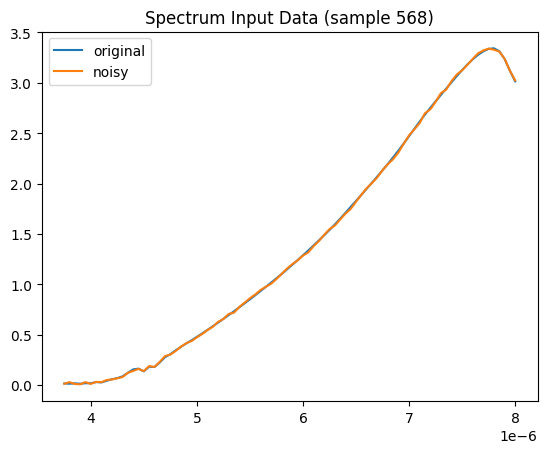

In [97]:
entry = random.randint(0, len(X))
plt.title(f'Spectrum Input Data (sample {entry})')
plt.plot(X.iloc[entry], label='original')
plt.plot(X_noisy.iloc[entry], label='noisy')
plt.legend()
plt.show()

In [98]:
scaler = args['scaler']
scaler.fit(X_noisy)
X_noisy_scaled = scaler.transform(X_noisy)

X_noisy_scaled_df = pd.DataFrame(X_noisy_scaled, columns=X.columns)

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X_noisy_scaled_df, y, train_size=args['train size'], random_state=101)

In [100]:
for layer in layers:
    layer['y_train'] = torch.tensor(y_train[layer['col']].values, dtype=torch.float32).reshape(-1,1)
    layer['y_test'] = torch.tensor(y_test[layer['col']].values, dtype=torch.float32).reshape(-1,1)

    layer['X_train'] = torch.tensor(X_train[layer['features']].values, dtype=torch.float32)
    layer['X_test'] = torch.tensor(X_test[layer['features']].values, dtype=torch.float32)

In [101]:
class FeedForward(nn.Module):
    def __init__(self, input_size, output_size, num_hidden):
        super(FeedForward, self).__init__()
        
        hidden_sizes = [input_size]
        step = input_size / (num_hidden+1)

        for i in range(num_hidden):
            hidden_size = int(input_size - (i+1) * step)
            if hidden_size < 1: hidden_size = 1
            hidden_sizes.append(hidden_size)
        
        self.hidden_layers = nn.ModuleList()

        for i in range(num_hidden):
            self.hidden_layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))

        self.hidden_sizes = hidden_sizes
        self.lin_fin = nn.Linear(hidden_sizes[-1], output_size)

    def forward(self, x):
        for hidden_layer in self.hidden_layers:
            x = F.leaky_relu(hidden_layer(x))
        x = self.lin_fin(x)
        return x

In [102]:
class BigNet(nn.Module):
    def __init__(self, input_size, output_size):
        super(BigNet, self).__init__()
        self.lin1 = nn.Linear(input_size, 80)
        self.lin2 = nn.Linear(80, 60)
        self.lin3 = nn.Linear(60, 40)
        self.lin4 = nn.Linear(40, 20)
        self.lin_fin = nn.Linear(20, output_size)

    def forward(self, x):
        x = F.leaky_relu(self.lin1(x))
        x = F.leaky_relu(self.lin2(x))
        x = F.leaky_relu(self.lin3(x))
        x = F.leaky_relu(self.lin4(x))
        x = self.lin_fin(x)
        return x

In [103]:
criterion = args['train criterion']

In [104]:
for layer in layers:
    inputs = layer['X_train']
    target = layer['y_train']

    # instantiate model
    model = FeedForward(inputs.size()[1], target.size()[1], args['hidden layers'])

    best_loss = np.inf
    best_epoch = 0
    train_losses = []

    optimizer = torch.optim.Rprop(model.parameters(), lr=args['lr'])

    print(layer['col'])
    print(f'hidden layer sizes: {model.hidden_sizes}')

    for epoch in range(args['train epochs']):
        # forward pass
        outputs = model(inputs)

        # get loss
        loss = criterion(outputs, target)

        # update and backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        
        if loss.item() < best_loss:
            best_loss = loss.item()
            best_epoch = epoch+1

        if (epoch+1) % int(args['train epochs']/10) == 0:
            print(f'epoch: {epoch+1}, loss = {loss}')

    # store model and losses
    layer['model'] = model
    layer['train losses'] = train_losses

    print(f'best loss: {best_loss} in epoch {best_epoch}\n')    

layer 1
hidden layer sizes: [86, 80, 75, 69, 64, 59, 53, 48, 43, 37, 32, 26, 21, 16, 10, 5]
epoch: 5, loss = 322.05242919921875
epoch: 10, loss = 188.06089782714844
epoch: 15, loss = 120.8021011352539
epoch: 20, loss = 108.75440216064453
epoch: 25, loss = 90.3225326538086
epoch: 30, loss = 59.98414993286133
epoch: 35, loss = 26.803434371948242
epoch: 40, loss = 15.491592407226562
epoch: 45, loss = 11.806921005249023
epoch: 50, loss = 10.57662296295166
best loss: 10.57662296295166 in epoch 50

layer 2
hidden layer sizes: [86, 80, 75, 69, 64, 59, 53, 48, 43, 37, 32, 26, 21, 16, 10, 5]
epoch: 5, loss = 322.713134765625
epoch: 10, loss = 224.302490234375
epoch: 15, loss = 154.8539581298828
epoch: 20, loss = 121.54822540283203
epoch: 25, loss = 105.54120635986328
epoch: 30, loss = 94.19281005859375
epoch: 35, loss = 86.64954376220703
epoch: 40, loss = 67.49308776855469
epoch: 45, loss = 38.078147888183594
epoch: 50, loss = 25.024812698364258
best loss: 25.024812698364258 in epoch 50

layer 

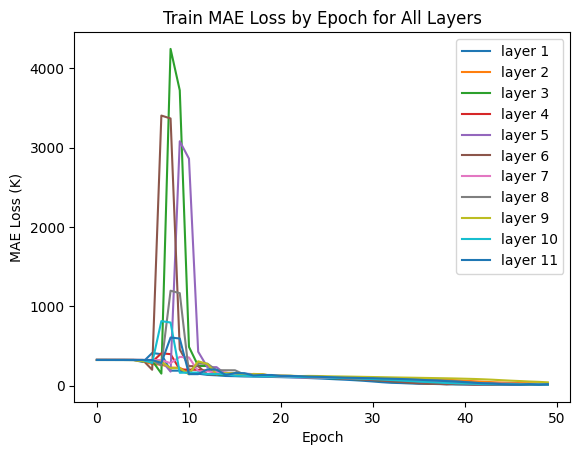

In [105]:
for layer in layers:
    plt.plot(layer['train losses'], label=layer['col'])

    
plt.title(f"Train MAE Loss by Epoch for All Layers")
plt.xlabel("Epoch")
plt.ylabel("MAE Loss (K)")
plt.legend()
plt.show()

In [106]:
model = BigNet(97, 11)
optimizer = torch.optim.Rprop(model.parameters(), lr=args['lr'])

best_loss = np.inf
best_epoch = 0
train_losses = []

inputs = X_train.copy()
for layer in layers:
    pred = layer['model'](layer['X_train'])
    pred = pd.DataFrame(pred.detach().numpy(), columns=[f'{layer["col"]} predictions'])
    inputs = pd.concat([inputs, pred], axis=1)

inputs = torch.tensor(inputs.values, dtype=torch.float32)
target = torch.tensor(y.values, dtype=torch.float32)

for epoch in range(args['train epochs']):
    # forward pass
    outputs = model(inputs)

    # get loss
    loss = criterion(outputs, target)

    # update and backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())
    
    if loss.item() < best_loss:
        best_loss = loss.item()
        best_epoch = epoch+1

    if (epoch+1) % int(args['train epochs']/10) == 0:
        print(f'epoch: {epoch+1}, loss = {loss}')


C:\Users\bthor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:101: UserWarning: Using a target size (torch.Size([2200, 11])) that is different to the input size (torch.Size([2012, 11])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (2012) must match the size of tensor b (2200) at non-singleton dimension 0

In [ ]:
test_losses = []
test_criterion = args['test criterion']

for layer in layers:
    inputs = layer['X_test']
    target = layer['y_test']
    model = layer['model']

    with torch.no_grad():
        pred = model(inputs)
        loss = test_criterion(pred, target)
        test_losses.append(loss.item())

    y_test[f'{layer["col"]} predictions'] = pred.numpy()
    print(f'{layer["col"]} loss: {loss.item()}')

layer 1 loss: 11.621498107910156
layer 2 loss: 11.859112739562988
layer 3 loss: 11.147527694702148
layer 4 loss: 11.28251838684082
layer 5 loss: 21.306150436401367
layer 6 loss: 16.404897689819336
layer 7 loss: 10.896260261535645
layer 8 loss: 10.53791618347168
layer 9 loss: 6.652839660644531
layer 10 loss: 15.612811088562012
layer 11 loss: 21.20020294189453


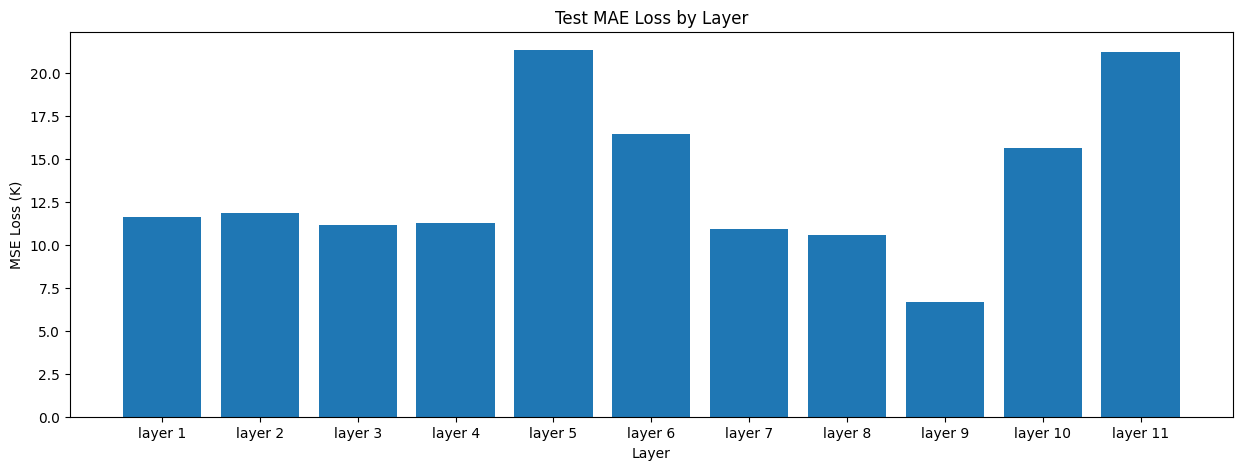

In [ ]:
plt.figure(figsize=(15, 5))
plt.bar(y.columns, test_losses)

plt.title("Test MAE Loss by Layer")
plt.xlabel("Layer")
plt.ylabel("MSE Loss (K)")

plt.show()

In [ ]:
def plot_comparison(pred, actual, sample):
    plt.figure(figsize=(15, 5))
    plt.title(f"Temperature Across Layers for Sample {sample}")
    plt.xlabel("Layer")
    plt.ylabel("Temperature (K)")
    plt.plot(pred, 'ro', label='predicted')
    plt.plot(actual, 'b', label='actual')
    plt.legend()
    plt.show()

In [ ]:
actual_df = y_test.iloc[:, :11]
pred_df = y_test.iloc[:, 11:]
pred_df.columns = actual_df.columns

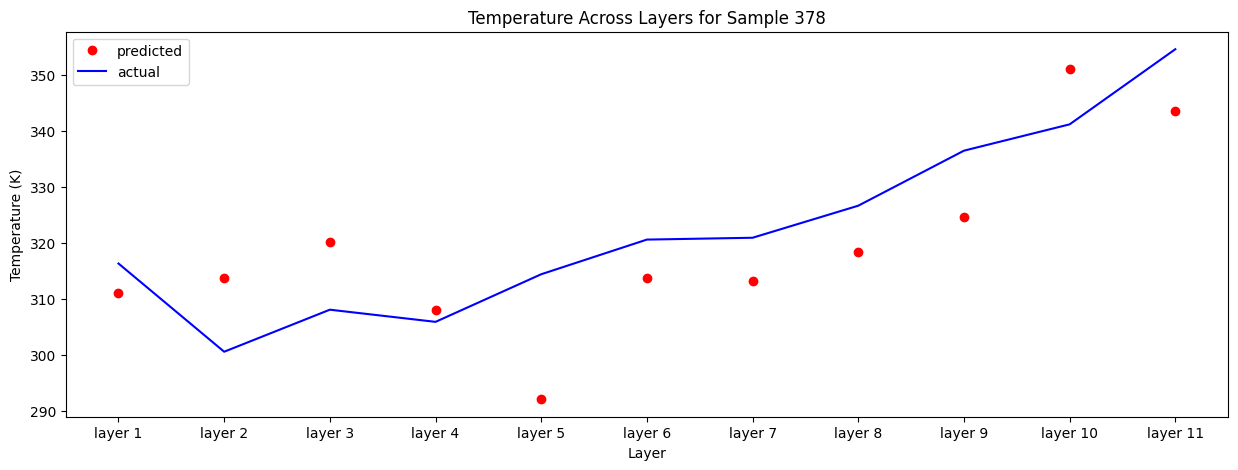

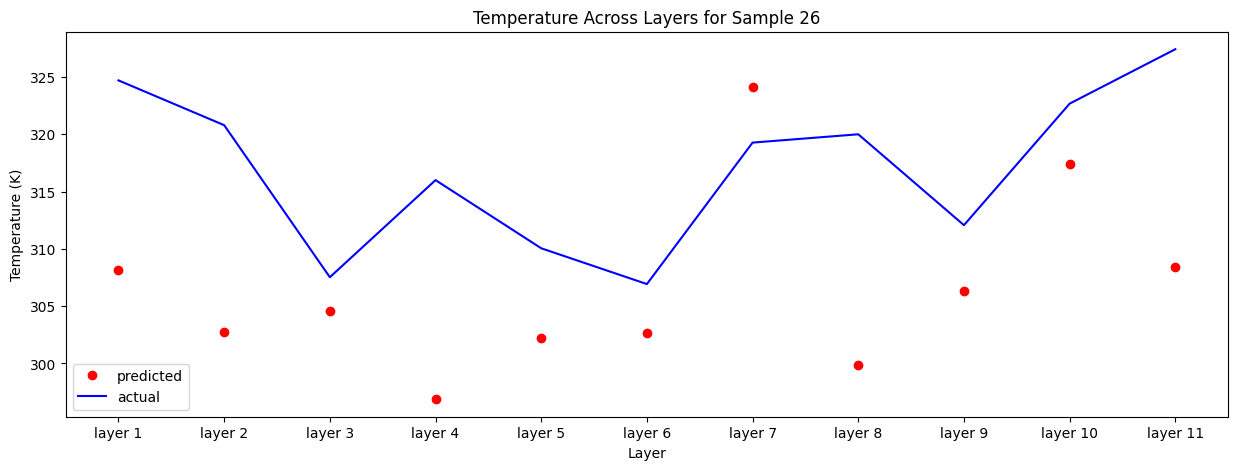

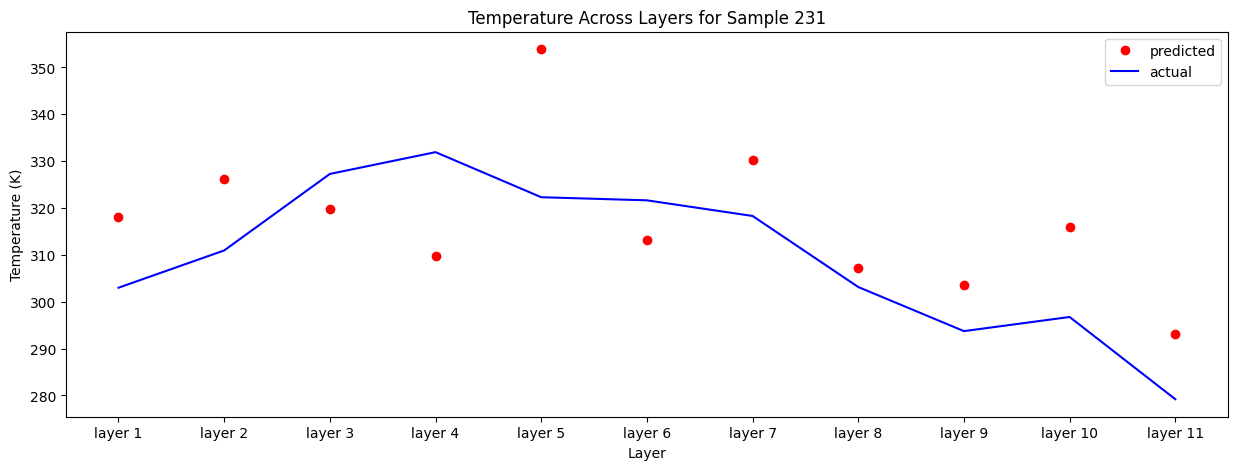

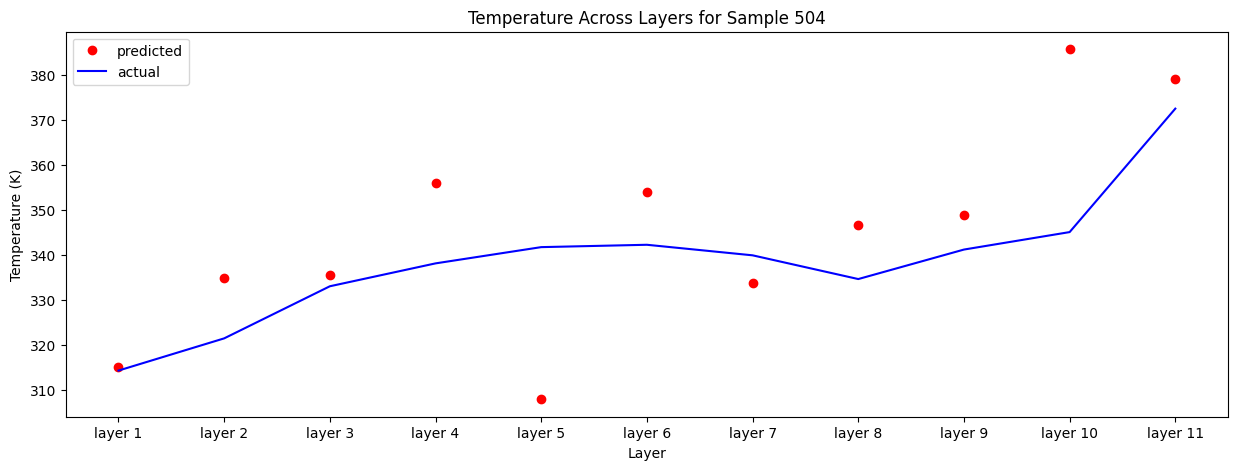

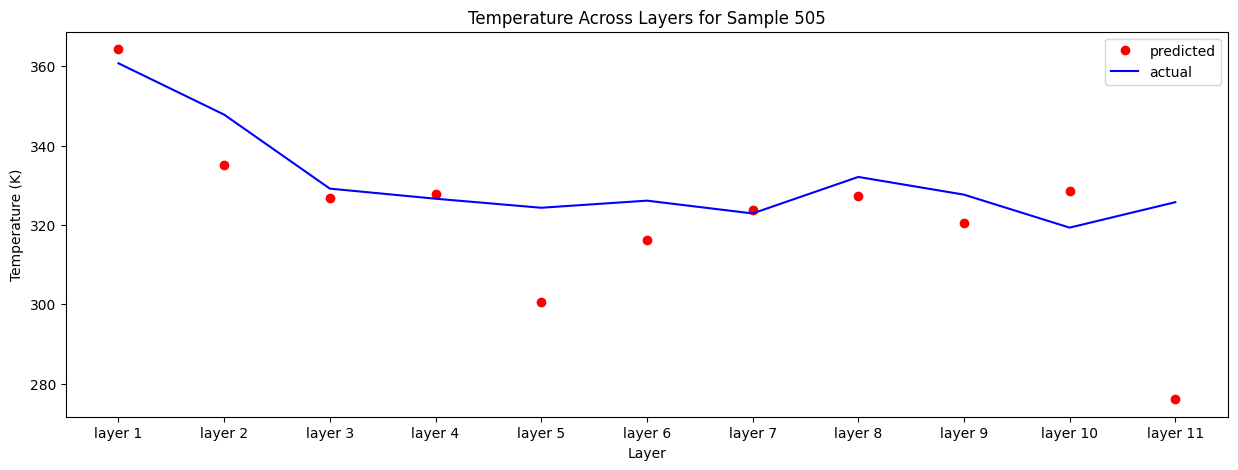

In [ ]:
indices = []
for i in range(0,5):
    n = random.randint(0, len(y_test))
    indices.append(n)

for i in indices:
    actual = actual_df.iloc[i,:]
    pred = pred_df.iloc[i,:]

    plot_comparison(pred, actual, i)